# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using hard data, survey information, and 10 sign-adjusted topics (BCC) (out of 200 topics estimated on articles published before 2010 using all sources) most correlated with Consumption growth. I forecast Consumption growth and integrate text data into economic forecasting.

## Experiment Details

- **Data Sources:** Hard data, surveys, 10 pre-selected sign-adjusted topics, BCC (<=2009, 200 topics, all sources).
- **Forecast Target:** Consumption growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Hard+Surveys Factors:** 1 to 2
  - **Number of Text Factors:** 1
  - **Factor Order:** 1 to 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Consumption'                     # quarterly variable being forecasted
additional_factors = 'HardSurveys+Text'   # switch to separate factors scenario
start = '1991-04'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""
with_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of HardSurveys factors (1 or 2) and factor order values from 1 to 3
for num_factors in range(1, 3):  # 1 or 2 HardSurveys factors
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'HardSurveys': num_factors, 'Text': 1}
        factor_orders = {'HardSurveys': order, 'Text': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start,
                text_type = text_type,
                estimation_period = estimation_period,
                num_topics = num_topics,
                source = source,
                selected = selected,
                with_text = with_text
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with HardSurveys factors = {num_factors} and order = {order} estimated in {elapsed_time}.")
        
        # Construct the output file name
        factors_str = f"HS_{num_factors}_{order}"
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-11813
EM converged at iteration 69, llf=-11546, convergence criterion=9.9087e-07 < tolerance=1e-06
EM start iterations, llf=-11826
EM converged at iteration 69, llf=-11558, convergence criterion=9.9015e-07 < tolerance=1e-06
EM start iterations, llf=-11879
EM converged at iteration 67, llf=-11608, convergence criterion=9.9732e-07 < tolerance=1e-06
EM start iterations, llf=-11886
EM converged at iteration 67, llf=-11615, convergence criterion=9.9712e-07 < tolerance=1e-06
EM start iterations, llf=-11948
EM converged at iteration 68, llf=-11672, convergence criterion=9.951e-07 < tolerance=1e-06
EM start iterations, llf=-11956
EM converged at iteration 68, llf=-11679, convergence criterion=9.9252e-07 < tolerance=1e-06
EM start iterations, llf=-12011
EM converged at iteration 69, llf=-11735, convergence criterion=9.7969e-07 < tolerance=1e-06
EM start iterations, llf=-12011
EM converged at iteration 69, llf=-11735, convergence criterion=9.7969e-07 < tolerance=1e-06
E

EM start iterations, llf=-13567
EM converged at iteration 55, llf=-13342, convergence criterion=9.9242e-07 < tolerance=1e-06
EM start iterations, llf=-13628
EM converged at iteration 53, llf=-13414, convergence criterion=9.7612e-07 < tolerance=1e-06
EM start iterations, llf=-13633
EM converged at iteration 53, llf=-13417, convergence criterion=9.7484e-07 < tolerance=1e-06
EM start iterations, llf=-13685
EM converged at iteration 52, llf=-13464, convergence criterion=9.7349e-07 < tolerance=1e-06
EM start iterations, llf=-13685
EM converged at iteration 52, llf=-13464, convergence criterion=9.7349e-07 < tolerance=1e-06
EM start iterations, llf=-13697
EM converged at iteration 52, llf=-13477, convergence criterion=9.7825e-07 < tolerance=1e-06
EM start iterations, llf=-13746
EM converged at iteration 52, llf=-13528, convergence criterion=9.7745e-07 < tolerance=1e-06
EM start iterations, llf=-13751
EM converged at iteration 52, llf=-13532, convergence criterion=9.767e-07 < tolerance=1e-06
E

EM start iterations, llf=-15309
EM converged at iteration 49, llf=-15069, convergence criterion=9.7045e-07 < tolerance=1e-06
EM start iterations, llf=-15309
EM converged at iteration 49, llf=-15069, convergence criterion=9.7045e-07 < tolerance=1e-06
EM start iterations, llf=-15319
EM converged at iteration 49, llf=-15078, convergence criterion=9.6974e-07 < tolerance=1e-06
EM start iterations, llf=-15373
EM converged at iteration 48, llf=-15132, convergence criterion=9.8019e-07 < tolerance=1e-06
EM start iterations, llf=-15384
EM converged at iteration 48, llf=-15143, convergence criterion=9.7712e-07 < tolerance=1e-06
EM start iterations, llf=-15433
EM converged at iteration 48, llf=-15192, convergence criterion=9.8095e-07 < tolerance=1e-06
EM start iterations, llf=-15441
EM converged at iteration 48, llf=-15199, convergence criterion=9.7882e-07 < tolerance=1e-06
EM start iterations, llf=-15487
EM converged at iteration 48, llf=-15244, convergence criterion=9.8388e-07 < tolerance=1e-06


EM start iterations, llf=-17021
EM converged at iteration 53, llf=-16743, convergence criterion=9.9485e-07 < tolerance=1e-06
EM start iterations, llf=-17025
EM converged at iteration 53, llf=-16748, convergence criterion=9.9501e-07 < tolerance=1e-06
EM start iterations, llf=-17077
EM converged at iteration 53, llf=-16799, convergence criterion=9.9956e-07 < tolerance=1e-06
EM start iterations, llf=-17084
EM converged at iteration 53, llf=-16806, convergence criterion=9.9982e-07 < tolerance=1e-06
EM start iterations, llf=-17139
EM converged at iteration 54, llf=-16861, convergence criterion=9.6519e-07 < tolerance=1e-06
EM start iterations, llf=-17139
EM converged at iteration 54, llf=-16861, convergence criterion=9.6519e-07 < tolerance=1e-06
EM start iterations, llf=-17148
EM converged at iteration 53, llf=-16871, convergence criterion=9.9979e-07 < tolerance=1e-06
EM start iterations, llf=-17202
EM converged at iteration 53, llf=-16925, convergence criterion=9.9032e-07 < tolerance=1e-06


EM start iterations, llf=-18541
EM converged at iteration 54, llf=-18247, convergence criterion=9.7916e-07 < tolerance=1e-06
EM start iterations, llf=-18599
EM converged at iteration 54, llf=-18303, convergence criterion=9.7154e-07 < tolerance=1e-06
EM start iterations, llf=-18599
EM converged at iteration 54, llf=-18303, convergence criterion=9.7154e-07 < tolerance=1e-06
EM start iterations, llf=-18604
EM converged at iteration 54, llf=-18309, convergence criterion=9.7149e-07 < tolerance=1e-06
EM start iterations, llf=-18659
EM converged at iteration 54, llf=-18361, convergence criterion=9.7282e-07 < tolerance=1e-06
EM start iterations, llf=-18665
EM converged at iteration 54, llf=-18369, convergence criterion=9.7218e-07 < tolerance=1e-06
EM start iterations, llf=-18721
EM converged at iteration 54, llf=-18422, convergence criterion=9.7336e-07 < tolerance=1e-06
EM start iterations, llf=-18729
EM converged at iteration 54, llf=-18430, convergence criterion=9.7326e-07 < tolerance=1e-06


EM start iterations, llf=-12359
EM converged at iteration 76, llf=-12065, convergence criterion=9.7864e-07 < tolerance=1e-06
EM start iterations, llf=-12341
EM converged at iteration 76, llf=-12045, convergence criterion=9.7555e-07 < tolerance=1e-06
EM start iterations, llf=-12394
EM converged at iteration 78, llf=-12109, convergence criterion=9.7975e-07 < tolerance=1e-06
EM start iterations, llf=-12413
EM converged at iteration 78, llf=-12134, convergence criterion=9.7773e-07 < tolerance=1e-06
EM start iterations, llf=-12480
EM converged at iteration 79, llf=-12222, convergence criterion=9.8436e-07 < tolerance=1e-06
EM start iterations, llf=-12479
EM converged at iteration 79, llf=-12219, convergence criterion=9.8029e-07 < tolerance=1e-06
EM start iterations, llf=-12504
EM converged at iteration 77, llf=-12251, convergence criterion=9.8257e-07 < tolerance=1e-06
EM start iterations, llf=-12504
EM converged at iteration 77, llf=-12251, convergence criterion=9.8257e-07 < tolerance=1e-06


EM start iterations, llf=-14109
EM converged at iteration 71, llf=-13873, convergence criterion=9.998e-07 < tolerance=1e-06
EM start iterations, llf=-14148
EM converged at iteration 71, llf=-13904, convergence criterion=9.775e-07 < tolerance=1e-06
EM start iterations, llf=-14154
EM converged at iteration 71, llf=-13917, convergence criterion=9.9754e-07 < tolerance=1e-06
EM start iterations, llf=-14204
EM converged at iteration 74, llf=-13974, convergence criterion=9.7756e-07 < tolerance=1e-06
EM start iterations, llf=-14204
EM converged at iteration 74, llf=-13974, convergence criterion=9.7756e-07 < tolerance=1e-06
EM start iterations, llf=-14214
EM converged at iteration 74, llf=-13985, convergence criterion=9.7935e-07 < tolerance=1e-06
EM start iterations, llf=-14268
EM converged at iteration 73, llf=-14037, convergence criterion=9.8187e-07 < tolerance=1e-06
EM start iterations, llf=-14275
EM converged at iteration 72, llf=-14044, convergence criterion=9.9539e-07 < tolerance=1e-06
EM

EM start iterations, llf=-15856
EM converged at iteration 66, llf=-15599, convergence criterion=9.9713e-07 < tolerance=1e-06
EM start iterations, llf=-15856
EM converged at iteration 66, llf=-15599, convergence criterion=9.9713e-07 < tolerance=1e-06
EM start iterations, llf=-15864
EM converged at iteration 66, llf=-15607, convergence criterion=9.8727e-07 < tolerance=1e-06
EM start iterations, llf=-15917
EM converged at iteration 66, llf=-15659, convergence criterion=9.9484e-07 < tolerance=1e-06
EM start iterations, llf=-15920
EM converged at iteration 66, llf=-15660, convergence criterion=9.9608e-07 < tolerance=1e-06
EM start iterations, llf=-15975
EM converged at iteration 66, llf=-15714, convergence criterion=9.9685e-07 < tolerance=1e-06
EM start iterations, llf=-15979
EM converged at iteration 66, llf=-15719, convergence criterion=9.9507e-07 < tolerance=1e-06
EM start iterations, llf=-16025
EM converged at iteration 66, llf=-15765, convergence criterion=9.989e-07 < tolerance=1e-06
E

EM start iterations, llf=-17573
EM converged at iteration 63, llf=-17297, convergence criterion=9.7586e-07 < tolerance=1e-06
EM start iterations, llf=-17578
EM converged at iteration 63, llf=-17303, convergence criterion=9.7502e-07 < tolerance=1e-06
EM start iterations, llf=-17633
EM converged at iteration 63, llf=-17356, convergence criterion=9.7396e-07 < tolerance=1e-06
EM start iterations, llf=-17641
EM converged at iteration 63, llf=-17362, convergence criterion=9.706e-07 < tolerance=1e-06
EM start iterations, llf=-17689
EM converged at iteration 63, llf=-17410, convergence criterion=9.7132e-07 < tolerance=1e-06
EM start iterations, llf=-17689
EM converged at iteration 63, llf=-17410, convergence criterion=9.7132e-07 < tolerance=1e-06
EM start iterations, llf=-17709
EM converged at iteration 63, llf=-17430, convergence criterion=9.7127e-07 < tolerance=1e-06
EM start iterations, llf=-17761
EM converged at iteration 62, llf=-17482, convergence criterion=9.9121e-07 < tolerance=1e-06
E

EM start iterations, llf=-19085
EM converged at iteration 62, llf=-18775, convergence criterion=9.8312e-07 < tolerance=1e-06
EM start iterations, llf=-19135
EM converged at iteration 62, llf=-18826, convergence criterion=9.7856e-07 < tolerance=1e-06
EM start iterations, llf=-19135
EM converged at iteration 62, llf=-18826, convergence criterion=9.7856e-07 < tolerance=1e-06
EM start iterations, llf=-19143
EM converged at iteration 62, llf=-18835, convergence criterion=9.7959e-07 < tolerance=1e-06
EM start iterations, llf=-19200
EM converged at iteration 62, llf=-18892, convergence criterion=9.7839e-07 < tolerance=1e-06
EM start iterations, llf=-19207
EM converged at iteration 62, llf=-18899, convergence criterion=9.7743e-07 < tolerance=1e-06
EM start iterations, llf=-19260
EM converged at iteration 61, llf=-18951, convergence criterion=9.8641e-07 < tolerance=1e-06
EM start iterations, llf=-19269
EM converged at iteration 61, llf=-18959, convergence criterion=9.8508e-07 < tolerance=1e-06


EM start iterations, llf=-12352
EM iteration 100, llf=-12054, convergence criterion=5.3993e-06
EM iteration 200, llf=-12050, convergence criterion=1.9352e-06
EM converged at iteration 247, llf=-12049, convergence criterion=9.938e-07 < tolerance=1e-06
EM start iterations, llf=-12335
EM iteration 100, llf=-12035, convergence criterion=5.3911e-06
EM iteration 200, llf=-12030, convergence criterion=1.9429e-06
EM converged at iteration 247, llf=-12029, convergence criterion=9.9799e-07 < tolerance=1e-06
EM start iterations, llf=-12388
EM iteration 100, llf=-12102, convergence criterion=2.62e-06
EM iteration 200, llf=-12099, convergence criterion=2.4391e-06
EM iteration 300, llf=-12097, convergence criterion=1.1475e-06
EM converged at iteration 317, llf=-12097, convergence criterion=9.9873e-07 < tolerance=1e-06
EM start iterations, llf=-12407
EM iteration 100, llf=-12127, convergence criterion=2.6271e-06
EM iteration 200, llf=-12124, convergence criterion=2.438e-06
EM iteration 300, llf=-1212

EM start iterations, llf=-13126
EM iteration 100, llf=-12880, convergence criterion=2.6469e-06
EM iteration 200, llf=-12877, convergence criterion=1.9946e-06
EM converged at iteration 292, llf=-12875, convergence criterion=9.9505e-07 < tolerance=1e-06
EM start iterations, llf=-13178
EM iteration 100, llf=-12929, convergence criterion=2.5382e-06
EM iteration 200, llf=-12926, convergence criterion=1.9633e-06
EM converged at iteration 293, llf=-12924, convergence criterion=9.9354e-07 < tolerance=1e-06
EM start iterations, llf=-13187
EM iteration 100, llf=-12938, convergence criterion=2.5357e-06
EM iteration 200, llf=-12935, convergence criterion=1.9617e-06
EM converged at iteration 293, llf=-12933, convergence criterion=9.9282e-07 < tolerance=1e-06
EM start iterations, llf=-13237
EM iteration 100, llf=-12989, convergence criterion=2.635e-06
EM iteration 200, llf=-12986, convergence criterion=1.9456e-06
EM converged at iteration 288, llf=-12984, convergence criterion=9.9981e-07 < tolerance

EM iteration 100, llf=-13768, convergence criterion=2.631e-06
EM iteration 200, llf=-13765, convergence criterion=1.7414e-06
EM converged at iteration 273, llf=-13763, convergence criterion=9.9495e-07 < tolerance=1e-06
EM start iterations, llf=-14039
EM iteration 100, llf=-13822, convergence criterion=2.7871e-06
EM iteration 200, llf=-13819, convergence criterion=1.7733e-06
EM converged at iteration 272, llf=-13817, convergence criterion=9.9502e-07 < tolerance=1e-06
EM start iterations, llf=-14039
EM iteration 100, llf=-13822, convergence criterion=2.7871e-06
EM iteration 200, llf=-13819, convergence criterion=1.7733e-06
EM converged at iteration 272, llf=-13817, convergence criterion=9.9502e-07 < tolerance=1e-06
EM start iterations, llf=-14051
EM iteration 100, llf=-13832, convergence criterion=2.7722e-06
EM iteration 200, llf=-13828, convergence criterion=1.7703e-06
EM converged at iteration 272, llf=-13827, convergence criterion=9.9409e-07 < tolerance=1e-06
EM start iterations, llf=

EM start iterations, llf=-14828
EM iteration 100, llf=-14589, convergence criterion=2.2517e-06
EM iteration 200, llf=-14587, convergence criterion=1.5468e-06
EM converged at iteration 266, llf=-14585, convergence criterion=9.9774e-07 < tolerance=1e-06
EM start iterations, llf=-14877
EM iteration 100, llf=-14640, convergence criterion=2.1142e-06
EM iteration 200, llf=-14637, convergence criterion=1.5425e-06
EM converged at iteration 270, llf=-14636, convergence criterion=9.9359e-07 < tolerance=1e-06
EM start iterations, llf=-14889
EM iteration 100, llf=-14657, convergence criterion=2.12e-06
EM iteration 200, llf=-14654, convergence criterion=1.5426e-06
EM converged at iteration 269, llf=-14653, convergence criterion=9.9973e-07 < tolerance=1e-06
EM start iterations, llf=-14939
EM iteration 100, llf=-14707, convergence criterion=2.0714e-06
EM iteration 200, llf=-14705, convergence criterion=1.5419e-06
EM converged at iteration 270, llf=-14703, convergence criterion=9.9979e-07 < tolerance=

EM converged at iteration 261, llf=-15409, convergence criterion=9.9981e-07 < tolerance=1e-06
EM start iterations, llf=-15673
EM iteration 100, llf=-15425, convergence criterion=1.358e-06
EM iteration 200, llf=-15423, convergence criterion=1.2387e-06
EM converged at iteration 261, llf=-15422, convergence criterion=9.9898e-07 < tolerance=1e-06
EM start iterations, llf=-15726
EM converged at iteration 83, llf=-15477, convergence criterion=9.9581e-07 < tolerance=1e-06
EM start iterations, llf=-15735
EM converged at iteration 83, llf=-15486, convergence criterion=9.9345e-07 < tolerance=1e-06
EM start iterations, llf=-15788
EM iteration 100, llf=-15541, convergence criterion=1.058e-06
EM iteration 200, llf=-15539, convergence criterion=1.0499e-06
EM converged at iteration 238, llf=-15539, convergence criterion=9.9838e-07 < tolerance=1e-06
EM start iterations, llf=-15794
EM iteration 100, llf=-15545, convergence criterion=1.0565e-06
EM iteration 200, llf=-15544, convergence criterion=1.0492e

EM start iterations, llf=-16761
EM converged at iteration 62, llf=-16489, convergence criterion=9.7685e-07 < tolerance=1e-06
EM start iterations, llf=-16761
EM converged at iteration 62, llf=-16489, convergence criterion=9.7685e-07 < tolerance=1e-06
EM start iterations, llf=-16767
EM converged at iteration 62, llf=-16501, convergence criterion=9.9408e-07 < tolerance=1e-06
EM start iterations, llf=-16819
EM converged at iteration 62, llf=-16553, convergence criterion=9.7722e-07 < tolerance=1e-06
EM start iterations, llf=-16824
EM converged at iteration 62, llf=-16555, convergence criterion=9.6871e-07 < tolerance=1e-06
EM start iterations, llf=-16879
EM converged at iteration 61, llf=-16608, convergence criterion=9.756e-07 < tolerance=1e-06
EM start iterations, llf=-16886
EM converged at iteration 61, llf=-16614, convergence criterion=9.72e-07 < tolerance=1e-06
EM start iterations, llf=-16934
EM converged at iteration 61, llf=-16660, convergence criterion=9.8711e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-18470
EM converged at iteration 67, llf=-18181, convergence criterion=9.9461e-07 < tolerance=1e-06
EM start iterations, llf=-18475
EM converged at iteration 67, llf=-18182, convergence criterion=9.8719e-07 < tolerance=1e-06
EM start iterations, llf=-18521
EM converged at iteration 67, llf=-18225, convergence criterion=9.858e-07 < tolerance=1e-06
EM start iterations, llf=-18535
EM converged at iteration 67, llf=-18243, convergence criterion=9.8864e-07 < tolerance=1e-06
EM start iterations, llf=-18385
EM converged at iteration 68, llf=-18086, convergence criterion=9.8884e-07 < tolerance=1e-06
EM start iterations, llf=-18385
EM converged at iteration 68, llf=-18086, convergence criterion=9.8884e-07 < tolerance=1e-06
EM start iterations, llf=-18393
EM converged at iteration 68, llf=-18098, convergence criterion=9.9342e-07 < tolerance=1e-06
EM start iterations, llf=-18448
EM converged at iteration 73, llf=-18155, convergence criterion=9.8866e-07 < tolerance=1e-06
E

EM start iterations, llf=-11410
EM converged at iteration 66, llf=-11243, convergence criterion=9.7836e-07 < tolerance=1e-06
EM start iterations, llf=-11465
EM converged at iteration 65, llf=-11299, convergence criterion=9.8554e-07 < tolerance=1e-06
EM start iterations, llf=-11476
EM converged at iteration 65, llf=-11308, convergence criterion=9.7678e-07 < tolerance=1e-06
EM start iterations, llf=-11533
EM converged at iteration 65, llf=-11360, convergence criterion=9.9427e-07 < tolerance=1e-06
EM start iterations, llf=-11533
EM converged at iteration 65, llf=-11360, convergence criterion=9.9427e-07 < tolerance=1e-06
EM start iterations, llf=-11538
EM converged at iteration 65, llf=-11367, convergence criterion=9.978e-07 < tolerance=1e-06
EM start iterations, llf=-11577
EM converged at iteration 65, llf=-11406, convergence criterion=9.8203e-07 < tolerance=1e-06
EM start iterations, llf=-11588
EM converged at iteration 65, llf=-11416, convergence criterion=9.8622e-07 < tolerance=1e-06
E

EM start iterations, llf=-13011
EM converged at iteration 52, llf=-12826, convergence criterion=9.9793e-07 < tolerance=1e-06
EM start iterations, llf=-13011
EM converged at iteration 52, llf=-12826, convergence criterion=9.9793e-07 < tolerance=1e-06
EM start iterations, llf=-13016
EM converged at iteration 53, llf=-12832, convergence criterion=9.717e-07 < tolerance=1e-06
EM start iterations, llf=-13056
EM converged at iteration 53, llf=-12872, convergence criterion=9.8252e-07 < tolerance=1e-06
EM start iterations, llf=-13065
EM converged at iteration 53, llf=-12881, convergence criterion=9.8267e-07 < tolerance=1e-06
EM start iterations, llf=-13123
EM converged at iteration 53, llf=-12938, convergence criterion=9.7812e-07 < tolerance=1e-06
EM start iterations, llf=-13141
EM converged at iteration 53, llf=-12955, convergence criterion=9.7115e-07 < tolerance=1e-06
EM start iterations, llf=-13191
EM converged at iteration 53, llf=-13005, convergence criterion=9.8385e-07 < tolerance=1e-06
E

EM start iterations, llf=-14642
EM converged at iteration 46, llf=-14448, convergence criterion=9.9617e-07 < tolerance=1e-06
EM start iterations, llf=-14649
EM converged at iteration 46, llf=-14455, convergence criterion=9.9442e-07 < tolerance=1e-06
EM start iterations, llf=-14697
EM converged at iteration 46, llf=-14503, convergence criterion=9.9973e-07 < tolerance=1e-06
EM start iterations, llf=-14704
EM converged at iteration 46, llf=-14511, convergence criterion=9.9892e-07 < tolerance=1e-06
EM start iterations, llf=-14750
EM converged at iteration 47, llf=-14556, convergence criterion=9.6734e-07 < tolerance=1e-06
EM start iterations, llf=-14750
EM converged at iteration 47, llf=-14556, convergence criterion=9.6734e-07 < tolerance=1e-06
EM start iterations, llf=-14762
EM converged at iteration 47, llf=-14567, convergence criterion=9.6712e-07 < tolerance=1e-06
EM start iterations, llf=-14805
EM converged at iteration 46, llf=-14610, convergence criterion=9.9956e-07 < tolerance=1e-06


EM start iterations, llf=-16298
EM converged at iteration 53, llf=-16093, convergence criterion=9.7306e-07 < tolerance=1e-06
EM start iterations, llf=-16350
EM converged at iteration 53, llf=-16145, convergence criterion=9.7899e-07 < tolerance=1e-06
EM start iterations, llf=-16350
EM converged at iteration 53, llf=-16145, convergence criterion=9.7899e-07 < tolerance=1e-06
EM start iterations, llf=-16360
EM converged at iteration 53, llf=-16154, convergence criterion=9.7661e-07 < tolerance=1e-06
EM start iterations, llf=-16413
EM converged at iteration 53, llf=-16206, convergence criterion=9.6967e-07 < tolerance=1e-06
EM start iterations, llf=-16423
EM converged at iteration 53, llf=-16216, convergence criterion=9.6849e-07 < tolerance=1e-06
EM start iterations, llf=-16471
EM converged at iteration 53, llf=-16264, convergence criterion=9.7059e-07 < tolerance=1e-06
EM start iterations, llf=-16482
EM converged at iteration 53, llf=-16274, convergence criterion=9.6979e-07 < tolerance=1e-06


EM start iterations, llf=-17753
EM converged at iteration 55, llf=-17535, convergence criterion=9.7581e-07 < tolerance=1e-06
EM start iterations, llf=-17803
EM converged at iteration 55, llf=-17586, convergence criterion=9.7687e-07 < tolerance=1e-06
EM start iterations, llf=-17812
EM converged at iteration 55, llf=-17594, convergence criterion=9.7634e-07 < tolerance=1e-06
EM start iterations, llf=-17864
EM converged at iteration 54, llf=-17645, convergence criterion=9.7866e-07 < tolerance=1e-06
EM start iterations, llf=-17871
EM converged at iteration 54, llf=-17652, convergence criterion=9.7834e-07 < tolerance=1e-06
EM start iterations, llf=-17923
EM converged at iteration 54, llf=-17704, convergence criterion=9.7548e-07 < tolerance=1e-06
EM start iterations, llf=-17923
EM converged at iteration 54, llf=-17704, convergence criterion=9.7548e-07 < tolerance=1e-06
EM start iterations, llf=-17930
EM converged at iteration 54, llf=-17711, convergence criterion=9.7589e-07 < tolerance=1e-06


EM start iterations, llf=-11911
EM converged at iteration 82, llf=-11743, convergence criterion=9.8984e-07 < tolerance=1e-06
EM start iterations, llf=-11933
EM converged at iteration 83, llf=-11757, convergence criterion=9.797e-07 < tolerance=1e-06
EM start iterations, llf=-11932
EM converged at iteration 81, llf=-11759, convergence criterion=9.9738e-07 < tolerance=1e-06
EM start iterations, llf=-11945
EM converged at iteration 81, llf=-11773, convergence criterion=9.9277e-07 < tolerance=1e-06
EM start iterations, llf=-11945
EM converged at iteration 81, llf=-11773, convergence criterion=9.9277e-07 < tolerance=1e-06
EM start iterations, llf=-11942
EM converged at iteration 82, llf=-11767, convergence criterion=9.822e-07 < tolerance=1e-06
EM start iterations, llf=-12001
EM converged at iteration 84, llf=-11827, convergence criterion=9.9799e-07 < tolerance=1e-06
EM start iterations, llf=-11999
EM converged at iteration 84, llf=-11825, convergence criterion=9.9488e-07 < tolerance=1e-06
EM

EM start iterations, llf=-13501
EM converged at iteration 77, llf=-13312, convergence criterion=9.9199e-07 < tolerance=1e-06
EM start iterations, llf=-13501
EM converged at iteration 77, llf=-13312, convergence criterion=9.9199e-07 < tolerance=1e-06
EM start iterations, llf=-13514
EM converged at iteration 77, llf=-13324, convergence criterion=9.917e-07 < tolerance=1e-06
EM start iterations, llf=-13566
EM converged at iteration 77, llf=-13376, convergence criterion=9.8228e-07 < tolerance=1e-06
EM start iterations, llf=-13572
EM converged at iteration 77, llf=-13383, convergence criterion=9.8047e-07 < tolerance=1e-06
EM start iterations, llf=-13628
EM converged at iteration 77, llf=-13438, convergence criterion=9.8806e-07 < tolerance=1e-06
EM start iterations, llf=-13638
EM converged at iteration 77, llf=-13447, convergence criterion=9.8464e-07 < tolerance=1e-06
EM start iterations, llf=-13690
EM converged at iteration 77, llf=-13498, convergence criterion=9.8576e-07 < tolerance=1e-06
E

EM start iterations, llf=-15168
EM converged at iteration 67, llf=-14970, convergence criterion=9.8479e-07 < tolerance=1e-06
EM start iterations, llf=-15167
EM converged at iteration 67, llf=-14970, convergence criterion=9.78e-07 < tolerance=1e-06
EM start iterations, llf=-15221
EM converged at iteration 65, llf=-15025, convergence criterion=9.987e-07 < tolerance=1e-06
EM start iterations, llf=-15226
EM converged at iteration 65, llf=-15030, convergence criterion=9.9845e-07 < tolerance=1e-06
EM start iterations, llf=-15273
EM converged at iteration 65, llf=-15075, convergence criterion=9.9568e-07 < tolerance=1e-06
EM start iterations, llf=-15273
EM converged at iteration 65, llf=-15075, convergence criterion=9.9568e-07 < tolerance=1e-06
EM start iterations, llf=-14733
EM converged at iteration 63, llf=-14549, convergence criterion=9.7671e-07 < tolerance=1e-06
EM start iterations, llf=-14924
EM converged at iteration 62, llf=-14739, convergence criterion=9.8439e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-16817
EM converged at iteration 64, llf=-16605, convergence criterion=9.7395e-07 < tolerance=1e-06
EM start iterations, llf=-16862
EM converged at iteration 64, llf=-16650, convergence criterion=9.7918e-07 < tolerance=1e-06
EM start iterations, llf=-16862
EM converged at iteration 64, llf=-16650, convergence criterion=9.7918e-07 < tolerance=1e-06
EM start iterations, llf=-16882
EM converged at iteration 64, llf=-16670, convergence criterion=9.7685e-07 < tolerance=1e-06
EM start iterations, llf=-16933
EM converged at iteration 64, llf=-16719, convergence criterion=9.8721e-07 < tolerance=1e-06
EM start iterations, llf=-16940
EM converged at iteration 64, llf=-16727, convergence criterion=9.8642e-07 < tolerance=1e-06
EM start iterations, llf=-16986
EM converged at iteration 64, llf=-16772, convergence criterion=9.8692e-07 < tolerance=1e-06
EM start iterations, llf=-16998
EM converged at iteration 64, llf=-16787, convergence criterion=9.8663e-07 < tolerance=1e-06


EM start iterations, llf=-18259
EM converged at iteration 63, llf=-18037, convergence criterion=9.9538e-07 < tolerance=1e-06
EM start iterations, llf=-18315
EM converged at iteration 63, llf=-18092, convergence criterion=9.8755e-07 < tolerance=1e-06
EM start iterations, llf=-18322
EM converged at iteration 63, llf=-18099, convergence criterion=9.868e-07 < tolerance=1e-06
EM start iterations, llf=-18376
EM converged at iteration 63, llf=-18152, convergence criterion=9.8289e-07 < tolerance=1e-06
EM start iterations, llf=-18384
EM converged at iteration 63, llf=-18161, convergence criterion=9.7907e-07 < tolerance=1e-06
EM start iterations, llf=-18437
EM converged at iteration 63, llf=-18214, convergence criterion=9.7534e-07 < tolerance=1e-06
EM start iterations, llf=-18437
EM converged at iteration 63, llf=-18214, convergence criterion=9.7534e-07 < tolerance=1e-06
EM start iterations, llf=-18448
EM converged at iteration 63, llf=-18222, convergence criterion=9.843e-07 < tolerance=1e-06
EM

EM iteration 200, llf=-11670, convergence criterion=2.1675e-06
EM converged at iteration 262, llf=-11669, convergence criterion=9.9027e-07 < tolerance=1e-06
EM start iterations, llf=-11916
EM iteration 100, llf=-11747, convergence criterion=2.7599e-06
EM iteration 200, llf=-11743, convergence criterion=2.5626e-06
EM iteration 300, llf=-11741, convergence criterion=1.2687e-06
EM converged at iteration 332, llf=-11741, convergence criterion=9.9684e-07 < tolerance=1e-06
EM start iterations, llf=-11903
EM iteration 100, llf=-11733, convergence criterion=2.7721e-06
EM iteration 200, llf=-11730, convergence criterion=2.5697e-06
EM iteration 300, llf=-11727, convergence criterion=1.2923e-06
EM converged at iteration 335, llf=-11727, convergence criterion=9.9322e-07 < tolerance=1e-06
EM start iterations, llf=-11926
EM iteration 100, llf=-11747, convergence criterion=2.2567e-06
EM iteration 200, llf=-11745, convergence criterion=2.328e-06
EM iteration 300, llf=-11742, convergence criterion=1.40

EM converged at iteration 306, llf=-12323, convergence criterion=9.9396e-07 < tolerance=1e-06
EM start iterations, llf=-12513
EM iteration 100, llf=-12334, convergence criterion=2.985e-06
EM iteration 200, llf=-12331, convergence criterion=2.1735e-06
EM iteration 300, llf=-12329, convergence criterion=1.0378e-06
EM converged at iteration 306, llf=-12329, convergence criterion=9.9267e-07 < tolerance=1e-06
EM start iterations, llf=-12566
EM iteration 100, llf=-12387, convergence criterion=2.8837e-06
EM iteration 200, llf=-12384, convergence criterion=2.1368e-06
EM iteration 300, llf=-12382, convergence criterion=1.0417e-06
EM converged at iteration 306, llf=-12382, convergence criterion=9.9724e-07 < tolerance=1e-06
EM start iterations, llf=-12578
EM iteration 100, llf=-12398, convergence criterion=2.8675e-06
EM iteration 200, llf=-12395, convergence criterion=2.1317e-06
EM iteration 300, llf=-12393, convergence criterion=1.0373e-06
EM converged at iteration 306, llf=-12393, convergence c

EM iteration 200, llf=-12989, convergence criterion=1.9152e-06
EM iteration 300, llf=-12988, convergence criterion=1.094e-06
EM converged at iteration 315, llf=-12987, convergence criterion=9.9424e-07 < tolerance=1e-06
EM start iterations, llf=-13231
EM iteration 100, llf=-13040, convergence criterion=2.5199e-06
EM iteration 200, llf=-13037, convergence criterion=1.9342e-06
EM converged at iteration 299, llf=-13035, convergence criterion=9.9432e-07 < tolerance=1e-06
EM start iterations, llf=-13243
EM iteration 100, llf=-13052, convergence criterion=2.511e-06
EM iteration 200, llf=-13049, convergence criterion=1.9304e-06
EM converged at iteration 298, llf=-13047, convergence criterion=9.9972e-07 < tolerance=1e-06
EM start iterations, llf=-13291
EM iteration 100, llf=-13099, convergence criterion=2.8479e-06
EM iteration 200, llf=-13096, convergence criterion=1.8699e-06
EM converged at iteration 284, llf=-13095, convergence criterion=9.9329e-07 < tolerance=1e-06
EM start iterations, llf=-

EM start iterations, llf=-14040
EM iteration 100, llf=-13846, convergence criterion=2.3255e-06
EM iteration 200, llf=-13843, convergence criterion=1.7007e-06
EM converged at iteration 285, llf=-13842, convergence criterion=9.9945e-07 < tolerance=1e-06
EM start iterations, llf=-14040
EM iteration 100, llf=-13846, convergence criterion=2.3255e-06
EM iteration 200, llf=-13843, convergence criterion=1.7007e-06
EM converged at iteration 285, llf=-13842, convergence criterion=9.9945e-07 < tolerance=1e-06
EM start iterations, llf=-14046
EM iteration 100, llf=-13853, convergence criterion=2.3273e-06
EM iteration 200, llf=-13850, convergence criterion=1.7002e-06
EM converged at iteration 285, llf=-13849, convergence criterion=9.9948e-07 < tolerance=1e-06
EM start iterations, llf=-14098
EM iteration 100, llf=-13906, convergence criterion=2.4329e-06
EM iteration 200, llf=-13903, convergence criterion=1.6457e-06
EM converged at iteration 276, llf=-13902, convergence criterion=9.9902e-07 < toleranc

EM converged at iteration 281, llf=-14596, convergence criterion=9.9654e-07 < tolerance=1e-06
EM start iterations, llf=-14854
EM iteration 100, llf=-14657, convergence criterion=1.7228e-06
EM iteration 200, llf=-14655, convergence criterion=1.4062e-06
EM converged at iteration 272, llf=-14653, convergence criterion=9.9892e-07 < tolerance=1e-06
EM start iterations, llf=-14865
EM iteration 100, llf=-14667, convergence criterion=1.7232e-06
EM iteration 200, llf=-14665, convergence criterion=1.4058e-06
EM converged at iteration 272, llf=-14664, convergence criterion=9.986e-07 < tolerance=1e-06
EM start iterations, llf=-14918
EM iteration 100, llf=-14722, convergence criterion=1.4694e-06
EM iteration 200, llf=-14720, convergence criterion=1.2968e-06
EM converged at iteration 272, llf=-14718, convergence criterion=9.9951e-07 < tolerance=1e-06
EM start iterations, llf=-14918
EM iteration 100, llf=-14722, convergence criterion=1.4694e-06
EM iteration 200, llf=-14720, convergence criterion=1.29

EM start iterations, llf=-15693
EM converged at iteration 61, llf=-15493, convergence criterion=9.7841e-07 < tolerance=1e-06
EM start iterations, llf=-15702
EM converged at iteration 61, llf=-15502, convergence criterion=9.7687e-07 < tolerance=1e-06
EM start iterations, llf=-15750
EM converged at iteration 60, llf=-15549, convergence criterion=9.9169e-07 < tolerance=1e-06
EM start iterations, llf=-15757
EM converged at iteration 60, llf=-15556, convergence criterion=9.9067e-07 < tolerance=1e-06
EM start iterations, llf=-15809
EM converged at iteration 60, llf=-15608, convergence criterion=9.9986e-07 < tolerance=1e-06
EM start iterations, llf=-15809
EM converged at iteration 60, llf=-15608, convergence criterion=9.9986e-07 < tolerance=1e-06
EM start iterations, llf=-15820
EM converged at iteration 61, llf=-15618, convergence criterion=9.7296e-07 < tolerance=1e-06
EM start iterations, llf=-15868
EM converged at iteration 62, llf=-15666, convergence criterion=9.7418e-07 < tolerance=1e-06


EM start iterations, llf=-17339
EM converged at iteration 85, llf=-17122, convergence criterion=9.9852e-07 < tolerance=1e-06
EM start iterations, llf=-17393
EM converged at iteration 79, llf=-17175, convergence criterion=9.9651e-07 < tolerance=1e-06
EM start iterations, llf=-17393
EM converged at iteration 79, llf=-17175, convergence criterion=9.9651e-07 < tolerance=1e-06
EM start iterations, llf=-17398
EM converged at iteration 80, llf=-17181, convergence criterion=9.8696e-07 < tolerance=1e-06
EM start iterations, llf=-17448
EM converged at iteration 80, llf=-17231, convergence criterion=9.9041e-07 < tolerance=1e-06
EM start iterations, llf=-17461
EM converged at iteration 80, llf=-17243, convergence criterion=9.8751e-07 < tolerance=1e-06
EM start iterations, llf=-17510
EM converged at iteration 81, llf=-17292, convergence criterion=9.9038e-07 < tolerance=1e-06
EM start iterations, llf=-17518
EM converged at iteration 81, llf=-17299, convergence criterion=9.881e-07 < tolerance=1e-06
E

EM converged at iteration 135, llf=-18271, convergence criterion=9.9418e-07 < tolerance=1e-06
EM start iterations, llf=-18551
EM iteration 100, llf=-18323, convergence criterion=1.3093e-06
EM converged at iteration 139, llf=-18322, convergence criterion=9.957e-07 < tolerance=1e-06
EM start iterations, llf=-18558
EM iteration 100, llf=-18329, convergence criterion=1.305e-06
EM converged at iteration 139, llf=-18328, convergence criterion=9.9338e-07 < tolerance=1e-06
EM start iterations, llf=-18602
EM iteration 100, llf=-18372, convergence criterion=1.4009e-06
EM converged at iteration 141, llf=-18371, convergence criterion=9.9337e-07 < tolerance=1e-06
EM start iterations, llf=-18602
EM iteration 100, llf=-18372, convergence criterion=1.4009e-06
EM converged at iteration 141, llf=-18371, convergence criterion=9.9337e-07 < tolerance=1e-06
EM start iterations, llf=-18323
EM iteration 100, llf=-18100, convergence criterion=1.4339e-06
EM converged at iteration 143, llf=-18099, convergence cr

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


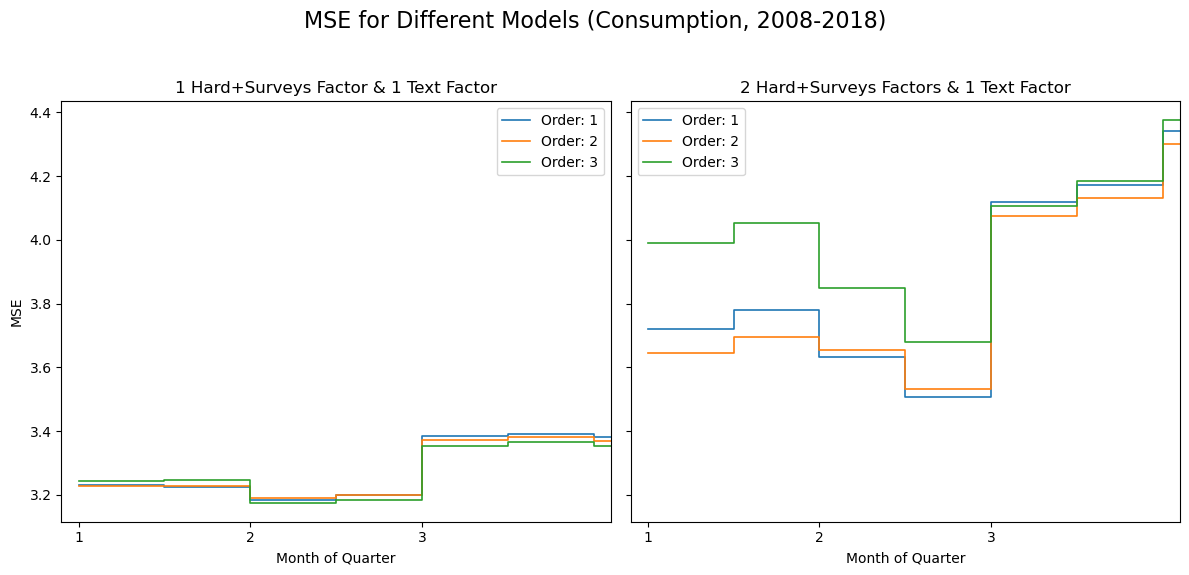

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}"

# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Loop over the number of HardSurveys factors (1 or 2)
for i, num_factors in enumerate(range(1, 3)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"HS_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


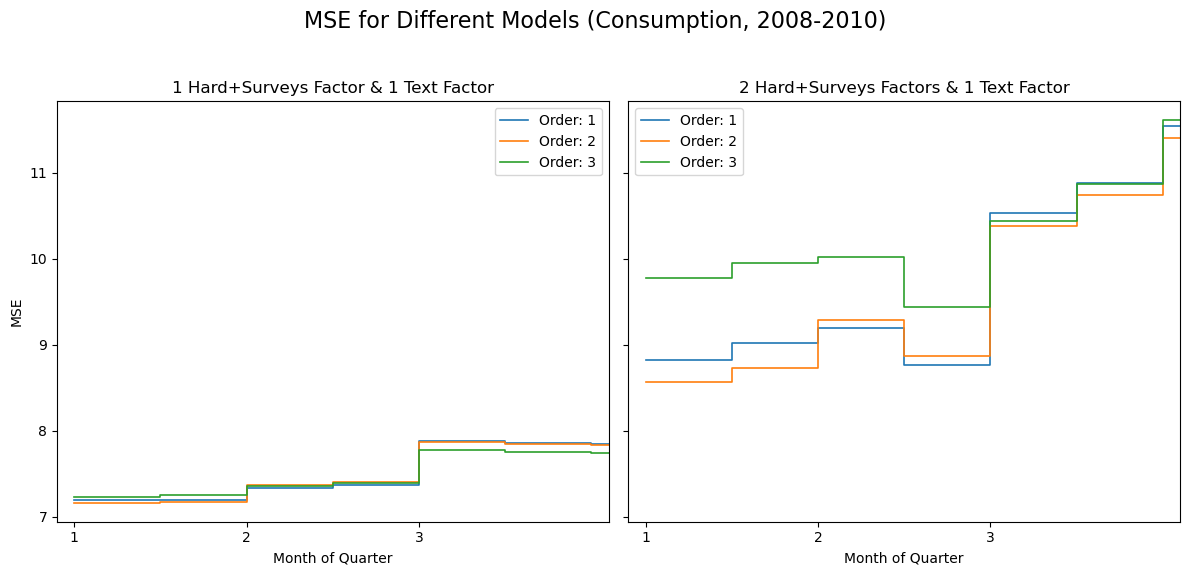

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


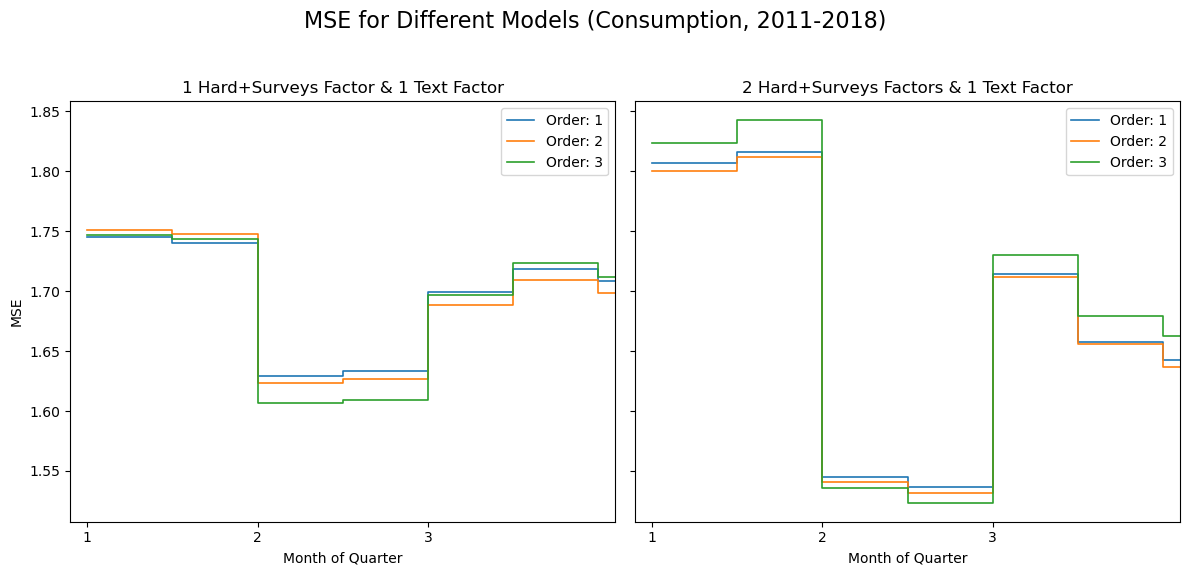

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 2 columns of subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    
    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate(range(1, 3)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


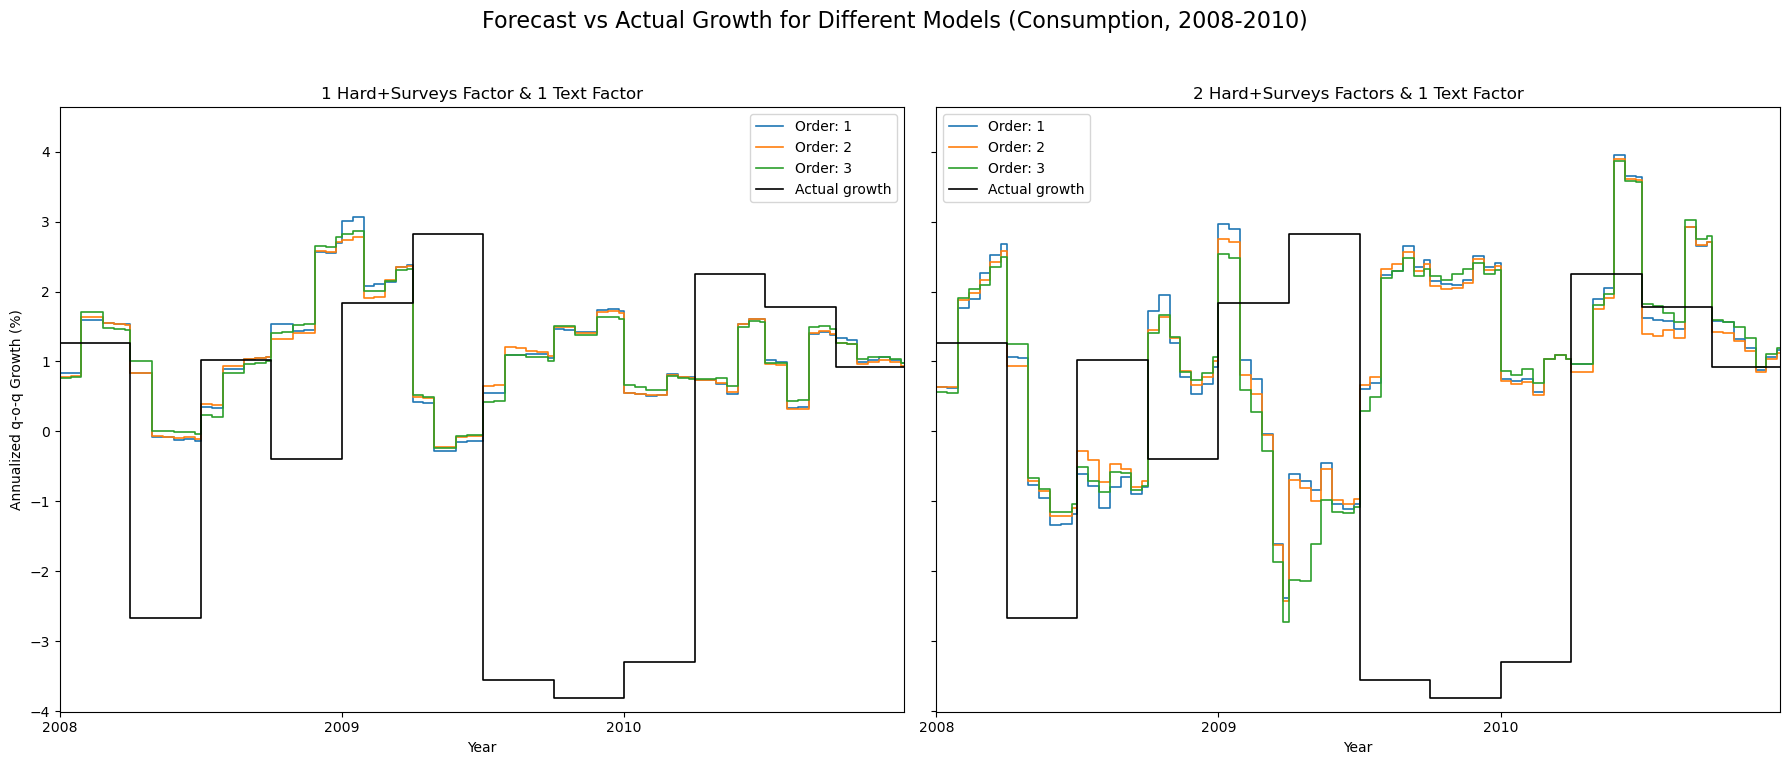

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


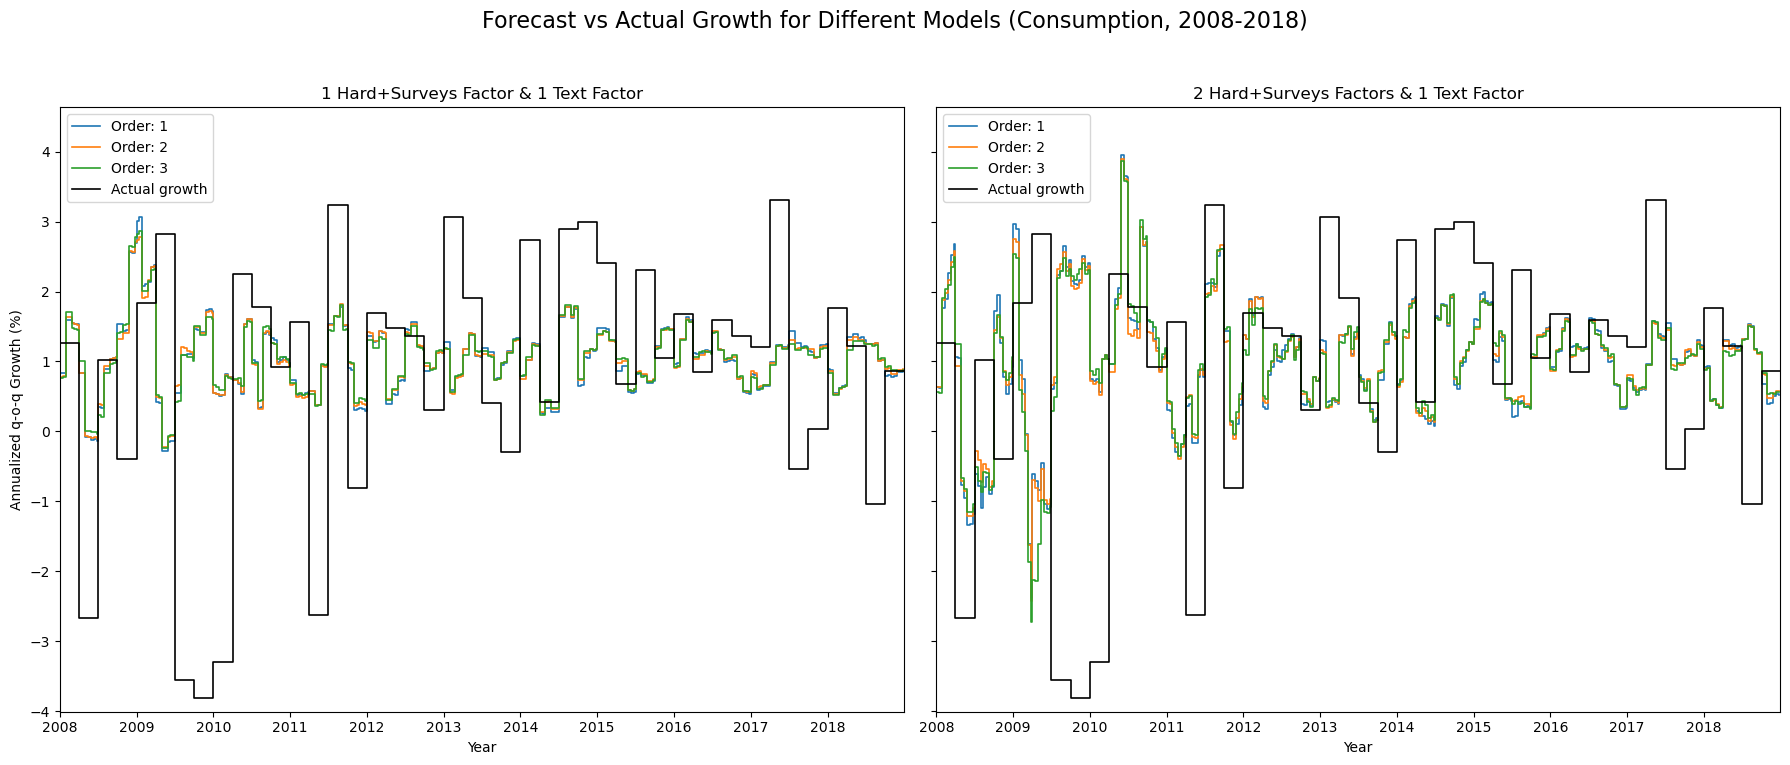

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


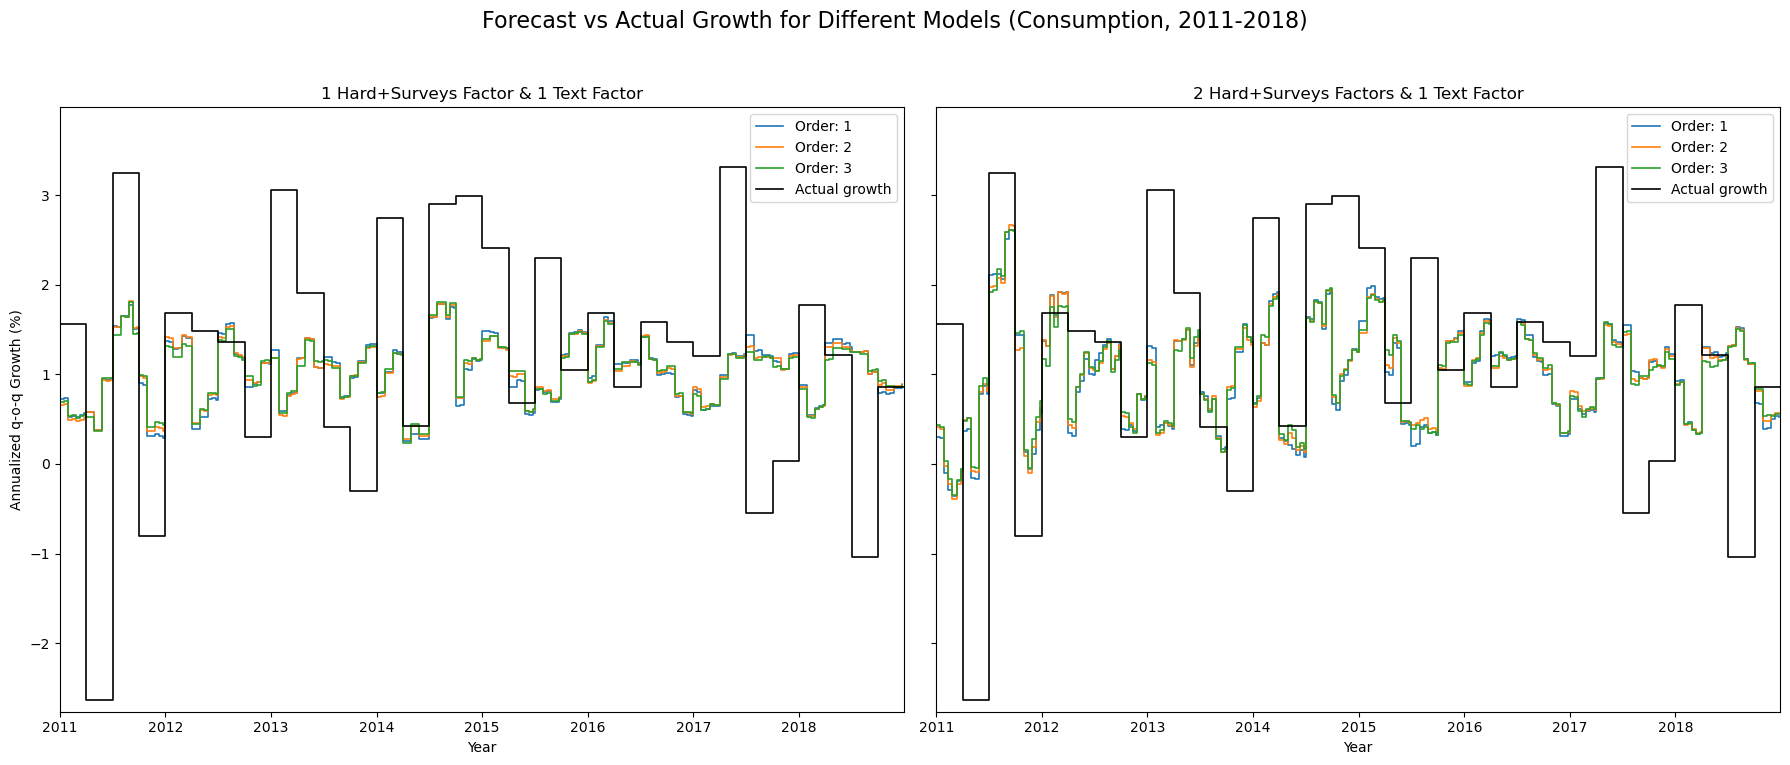

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Consumption'
text_type = "topics_BCC"
estimation_period = "2009"
num_topics = "200"
source = "all"
selected = ""
forecasts_dir = f"../forecasts/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a figure with 1 row and 2 columns for the two Hard+Surveys factor counts
    fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

    # Loop over the number of HardSurveys factors (1 or 2)
    for i, num_factors in enumerate([1, 2]):
        ax = axs[i]

        # For each HardSurveys factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_Consumption_HS_1_1.csv"
            factors_str = f"HS_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        
        # Set y-axis limits based on the data within the period range
        x_min, x_max = config["xlim"]
        def filter_points(x_arr, y_arr, x_min, x_max):
            return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

        # Filter y-values
        y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
        y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)
        
        # Combine all filtered y-values
        combined_y = y_filtered + y_act_filtered
        ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))
        
        ax.set_title(f"{num_factors} Hard+Surveys Factor{'s' if num_factors > 1 else ''} & 1 Text Factor")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_{q_var}", f"DFM_{text_type}_{estimation_period}_{num_topics}_{source}{selected}_separate_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()